# Imports

In [13]:
import pickle
import pandas as pd

# 0) Charger les données

In [14]:
path="./PPG_FieldStudy/S1/S1.pkl"

In [15]:
with open(path, "rb") as f:
    data = pickle.load(f, encoding="latin-1")

# 1) Explorer les données

In [16]:
print(data.keys())

dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])


In [17]:
data['questionnaire']

{'WEIGHT': 78.0,
 'Gender': ' m',
 'AGE': 34,
 'HEIGHT': 182.0,
 'SKIN': 3,
 'SPORT': 6}

In [18]:
pd.DataFrame(data['signal'])

,chest,wrist
ACC,"[[0.8564000129699707, -0.06779998540878296, -0...","[[-0.765625, -0.078125, 0.671875], [-0.765625,..."
ECG,"[[0.015609741210937498], [0.01812744140625], [...",NaN
EMG,"[[-1.5], [-1.5], [-1.5], [-1.5], [-1.5], [-1.5...",NaN
EDA,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[4.722437], [4.728843], [4.718594], [4.717312..."
Temp,"[[-273.15], [-273.15], [-273.15], [-273.15], [...",NaN
Resp,"[[4.44183349609375], [4.45098876953125], [4.47...",NaN
BVP,NaN,"[[7.28], [6.33], [5.46], [4.6], [3.74], [2.86]..."
TEMP,NaN,"[[32.13], [32.16], [32.16], [32.16], [32.16], ..."


### Les données sont réparties de la manière suivante :
- rpeaks : qui contient l'index des rpeaks enregistré par l'ECG (echocardiogramme) en 700Hz
- signal : qui contient les valeurs des capteurs disposé sur le patient au niveau de la poitrine (chest) et du poignet (wrist)
- label : qui contient le rythme cardiaque (heart rate) moyen instantané pris par l'ECG sur une fenêtre de 8 secondes avec glissement de 2 secondes
- activity : qui contient l'id des activités effectué par le patient
    - 0 : transition d'une activité à une autre
    - 1 : s'asseoir
    - 2 : monter et descendre des excaliers
    - 3 : babyfoot
    - 4 : faire du vélo
    - 5 : conduire
    - 6 : déjeuner
    - 7 : marcher
    - 8 : travailler
- questionnaire : les informations personnelles du patient (age, poids, taille, sexe, type de peau, niveau d'activité physique sur une échelle de 1-6)
- subject : id du patient


# 2) Tranformer les données

Dans l'état actuel des données, il est difficile d'analyser les différentes variables. Il faut donc transformer les données.

L'idée est d'obtenir un dataframe avec toutes les données de tous les clients.

De plus, comme les capteurs/appareils utilisés pour capturer les données n'avaient pas la même fréquence, le nombre de lignes de chaque colonne ne correspondent pas, c'est pourquoi il faut tous les mettre sur la même. J'ai décidé de tout mettre sur la fréquence 4Hz.


## 2.1) Transformer les données d'un patient dans une dataframe

Les changements à effectuer sont donc les suivants :

### 'activity' (4Hz) :
- Transformer en colonne d'un dataframe

### 'subject' :
- Transformer en colonne d'un dataframe
- Répéter l'id du sujet sur toutes les lignes le concernant

### 'questionnaire' :
- Transformer en plusieurs colonnes d'un dataframe
- Répéter les infos weight, age, gender, height, skin, sport sur toutes lignes concernant le même patient
- Pour "gender", transformer en "male" 1 pour True et 0 pour False

### 'label' (fenêtre de 8 sec avec glissement de 2 sec) :
- Transformer en colonne d'un dataframe
- On multiplie par 8 chaque valeur pour avoir la bonne fréquence

### 'rpeaks' (capteur de 700Hz) :
- Transformer en colonne d'un dataframe
- Comme ça correspond à l'index de chaque rpeak du patient, on peut donc calculer le nombre de rpeaks par 0.25 seconde (ce qui correspond à 4Hz), c'est-à-dire le nombre d'index compris entre des intervalles de 700/4 = 175.

In [19]:
dfs  = []
pbms = []
oks  = []
for k in data.keys():
    if k != "signal":
        try:
            if k == 'activity':
                df = pd.DataFrame(data[k], columns=['activity']) 
                dfs.append(df)
                oks.append(k)
            elif k == 'subject':
                df = pd.DataFrame([data[k]] * len(data['activity']), columns=['subject'])
                dfs.append(df)
                oks.append(k)
            elif k == 'questionnaire':
                for key in data[k].keys():
                    if key == 'Gender':
                        if data[k][key] == ' m':
                            df = pd.DataFrame([1] * len(data['activity']), columns=['male'])
                        if data[k][key] == ' f':
                            df = pd.DataFrame([0] * len(data['activity']), columns=['male'])
                    else:
                        df = pd.DataFrame([data[k][key]] * len(data['activity']), columns=[key.lower()])
                    dfs.append(df)
                oks.append(k)
            elif k == 'label':
                lab = []
                count = 0
                for i in range(0,len(data[k])):
                    while(count != 8):
                        count = count+1
                        lab.append(data[k][i])
                    count = 0
                    if i == len(data[k])-1:
                        while(count != 8*3):
                            count = count+1
                            lab.append(data[k][i])
                df = pd.DataFrame({k : lab })
                dfs.append(df)
                oks.append(k)
            elif k == 'rpeaks':
                nbitem = 0
                rpeaknb = []
                count = 0
                for i in range(0, int(max(data[k])/175)+1):
                    for item in data[k][nbitem:]:
                        if item >= i*175 and item < (i+1)*175:
                            count = count + 1
                            nbitem = nbitem+1
                        else: break
                    rpeaknb.append(count)
                    count = 0
                df = pd.DataFrame({'rpeakcount' : rpeaknb })
                dfs.append(df)
                oks.append(k)
            else:
                df = pd.DataFrame({k : data[k] }) 
                dfs.append(df)
                oks.append(k)
        except Exception as e:
            pbms.append(k + str(e))
print(f"clefs ok = {oks}")
print(f"clefs avec un pbms = {pbms}")

# Pour fusionner tous les dataframes
dataDf = pd.concat(dfs, axis=1)

clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []


### 'signal' :
#### - 'chest' (700Hz) :
- Transformer en plusieurs colonne d'un dataframe :
    - ACC : pour l'accéléromètre
    - ECG : pour l'échocardiogramme
    - Resp : pour la respiration
- Toutes les données ont été capturées en 700Hz, il faut donc les mettre en 4Hz, pour cela on prend donc 1 valeur sur 175
- Certaines colonnes sont inutiles comme: Temp, EMG et EDA (pour chest).

#### - 'wrist' (32Hz, 64Hz, 4Hz) :
- Transformer en plusieurs colonne d'un dataframe :
    - ACC : pour l'accéléromètre (en 32Hz)
    - BVP : pour Blood Volume Pulse (en 64Hz)
    - EDA : pour la niveau de conductance de la peau (déjà en 4Hz)
    - Temps : pour la température déjà en (4Hz)
- Les données ont été capturées à des fréquences différentes, il faut donc tous les mettre à 4Hz. Pour le 32Hz, ça revient à prendre 1 valeur sur 8 et pour 64Hz, 1 valeur sur 16.
- Certaines colonnes sont inutiles comme: Temp, EMG et EDA (pour chest).

In [20]:
signal = pd.DataFrame(data['signal'])
signal = signal.drop(index=['Temp', 'EMG']) # Supprimer les données inutiles d'après la doc

signalDfs = []
for key in signal.keys():
    for index in list(signal.index.values):
        try:
            d = signal.at[index, key]
            if key == 'chest':
                df = pd.DataFrame(d[::175])
            elif key == 'wrist' and index == 'ACC':
                df = pd.DataFrame(d[::8])
            elif key == 'wrist' and index == 'BVP':
                df = pd.DataFrame(d[::16])
            else:
                df = pd.DataFrame(d)
            for k in df.keys():
                df = df.rename(columns={k: key + index + str(k)})
            signalDfs.append(df)
        except Exception as e:
            print("Not working (NaN values): "+key+","+index)

# Pour fusionner tous les dataframes de signal
signalDf = pd.concat(signalDfs, axis=1)
# Pour enlever la colonne chestEDA0 qui est inutile d'après la documentation
signalDf = signalDf.drop(columns='chestEDA0')

Not working (NaN values): chest,BVP
Not working (NaN values): chest,TEMP
Not working (NaN values): wrist,ECG
Not working (NaN values): wrist,Resp


## 2.2) Fusionner les dataframes d'un patient

In [21]:
dataframe = pd.concat([dataDf, signalDf], axis=1)
# Pour retirer les lignes où au moins une des colonnes est vide
dataframe = dataframe.dropna()
dataframe.sample(5)

,rpeakcount,label,activity,weight,male,age,height,skin,sport,subject,...,chestACC1,chestACC2,chestECG0,chestResp0,wristACC0,wristACC1,wristACC2,wristEDA0,wristBVP0,wristTEMP0
28403,1.0,89.151603,7.0,78.0,1,34,182.0,3,6,S1,...,-0.1510,-0.1666,-0.177200,1.966858,-0.265625,0.406250,0.156250,4.219437,27.60,33.93
6074,0.0,77.040386,3.0,78.0,1,34,182.0,3,6,S1,...,-0.2498,-0.0388,-0.144333,-3.703308,-0.953125,0.468750,-0.109375,9.779117,-30.28,30.51
28768,1.0,80.534873,7.0,78.0,1,34,182.0,3,6,S1,...,0.1522,-0.4802,0.256577,-0.798035,-0.359375,1.765625,0.562500,4.166908,26.75,33.66
36767,0.0,63.734886,0.0,78.0,1,34,182.0,3,6,S1,...,-0.0740,-0.6198,-0.114395,6.517029,-0.531250,0.000000,0.859375,2.692675,2.94,34.37
35004,0.0,71.482331,8.0,78.0,1,34,182.0,3,6,S1,...,-0.0822,-0.5142,-0.105835,-3.324890,-0.359375,-0.015625,0.953125,2.385255,43.00,34.33


## 2.3) Fusionner les données de tous les patients dans un seul dataframe

### Faire une fonction pour créer le dataframe d'un client

On va mettre le code effectué en 2.1) et 2.2) dans une fonction qui nous retournera le dataframe d'un patient

In [22]:
def createPatientDataframe(data):
    dfs  = []
    pbms = []
    oks  = []
    for k in data.keys():
        if k != "signal":
            try:
                if k == 'activity':
                    df = pd.DataFrame(data[k], columns=['activity']) 
                    dfs.append(df)
                    oks.append(k)
                elif k == 'subject':
                    df = pd.DataFrame([data[k]] * len(data['activity']), columns=['subject'])
                    dfs.append(df)
                    oks.append(k)
                elif k == 'questionnaire':
                    for key in data['questionnaire'].keys():
                        if key == 'Gender':
                            if data[k][key] == ' m':
                                df = pd.DataFrame([1] * len(data['activity']), columns=['male'])
                            if data[k][key] == ' f':
                                df = pd.DataFrame([0] * len(data['activity']), columns=['male'])
                        else:
                            df = pd.DataFrame([data[k][key]] * len(data['activity']), columns=[key.lower()])
                        dfs.append(df)
                    oks.append(k)
                elif k == 'label':
                    lab = []
                    count = 0
                    for i in range(0,len(data[k])):
                        while(count != 8):
                            count = count+1
                            lab.append(data[k][i])
                        count = 0
                        if i == len(data[k])-1:
                            while(count != 8*3):
                                count = count+1
                                lab.append(data[k][i])
                    df = pd.DataFrame({k : lab })
                    dfs.append(df)
                    oks.append(k)
                elif k == 'rpeaks':
                    nbitem = 0
                    rpeaknb = []
                    count = 0
                    for i in range(0, int(max(data[k])/175)+1):
                        for item in data[k][nbitem:]:
                            if item >= i*175 and item < (i+1)*175:
                                count = count + 1
                                nbitem = nbitem+1
                            else: break
                        rpeaknb.append(count)
                        count = 0
                    df = pd.DataFrame({'rpeakcount' : rpeaknb })
                    dfs.append(df)
                    oks.append(k)
                else:
                    df = pd.DataFrame({k : data[k] }) 
                    dfs.append(df)
                    oks.append(k)
            except Exception as e:
                pbms.append(k + str(e))
    print(f"clefs ok = {oks}")
    print(f"clefs avec un pbms = {pbms}")

    # Pour fusionner tous les dataframes
    dataDf = pd.concat(dfs, axis=1)
    
    signal = pd.DataFrame(data['signal'])
    signal = signal.drop(index=['Temp', 'EMG']) # Supprimer les données inutiles d'après la doc
    signalDfs = []
    for key in signal.keys():
        for index in list(signal.index.values):
            try:
                d = signal.at[index, key]
                if key == 'chest':
                    df = pd.DataFrame(d[::175])
                elif key == 'wrist' and index == 'ACC':
                    df = pd.DataFrame(d[::8])
                elif key == 'wrist' and index == 'BVP':
                    df = pd.DataFrame(d[::16])
                else:
                    df = pd.DataFrame(d)
                for k in df.keys():
                    df = df.rename(columns={k: key + index + str(k)})
                signalDfs.append(df)
            except Exception as e:
                print()
    # Pour fusionner tous les dataframes de signal
    signalDf = pd.concat(signalDfs, axis=1)
    # Pour enlever la colonne chestEDA0 qui est inutile d'après la documentation
    signalDf = signalDf.drop(columns='chestEDA0')
    dataframe = pd.concat([dataDf, signalDf], axis=1)
    # Pour retirer les lignes où au moins une des colonnes est vide
    dataframe = dataframe.dropna()
    return dataframe

### Mettre les données de tous les patients dans un seul dataframe

On va faire une boucle pour pouvoir tout ajouter dans le même dataframe.

In [23]:
datasList = []
for i in range(1,16):
    path = "./PPG_FieldStudy/S"+str(i) + "/S"+str(i)+".pkl"
    print("Opening : "+path)
    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin-1")
    dataframe = createPatientDataframe(data)
    datasList.append(dataframe)


Opening : ./PPG_FieldStudy/S1/S1.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S2/S2.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S3/S3.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S4/S4.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S5/S5.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S6/S6.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S7/S7.pkl
clefs ok = ['rpeaks', 'label', 'activity', 'questionnaire', 'subject']
clefs avec un pbms = []




Opening : ./PPG_FieldStudy/S8/S8.pkl
clefs ok = 

In [24]:
datas = pd.concat(datasList, axis=0)

In [25]:
datas.sample(5)

,rpeakcount,label,activity,weight,male,age,height,skin,sport,subject,...,chestACC1,chestACC2,chestECG0,chestResp0,wristACC0,wristACC1,wristACC2,wristEDA0,wristBVP0,wristTEMP0
8146,1.0,81.789569,0.0,60.0,0,28,167.0,4,5,S9,...,0.0826,-0.1070,-0.088394,-2.323914,-0.609375,0.750000,0.390625,2.359281,2.11,31.49
11717,0.0,146.911673,0.0,70.0,0,21,180.0,3,4,S5,...,-0.2090,-0.1998,-0.494843,12.940979,-0.796875,-0.718750,-0.078125,14.835396,105.86,34.84
31644,1.0,76.204136,8.0,78.0,1,34,182.0,3,6,S1,...,-0.1116,-0.5410,0.033188,-2.127075,-0.375000,-0.015625,0.937500,4.224561,33.62,33.84
23631,0.0,92.652416,7.0,79.0,1,28,183.0,2,5,S15,...,0.0418,-0.1050,-1.499359,-1.673889,-0.296875,-0.312500,0.390625,5.954992,17.72,33.71
20548,0.0,91.208212,6.0,62.0,0,24,168.0,3,5,S11,...,-0.0402,-0.1680,-0.052917,-1.176453,-0.765625,-0.609375,-0.250000,1.776238,17.96,35.00


# 3) Visualisation des données

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

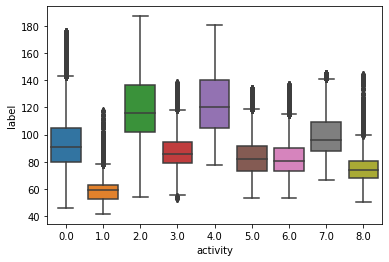

In [27]:
sns.boxplot(x="activity", y="label", data=datas)

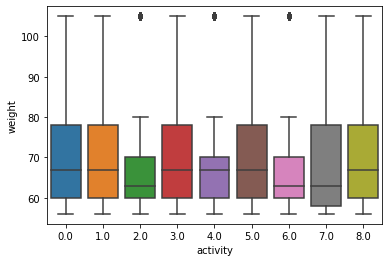

In [28]:
sns.boxplot(x="activity", y="weight", data=datas)

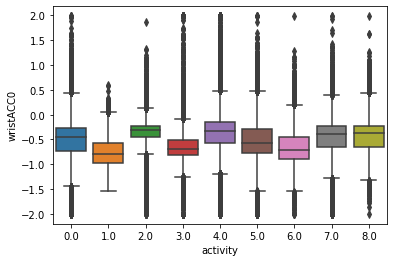

In [29]:
sns.boxplot(x="activity", y="wristACC0", data=datas)

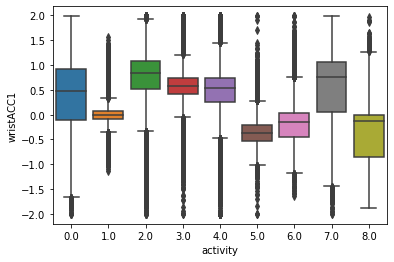

In [30]:
sns.boxplot(x="activity", y="wristACC1", data=datas)

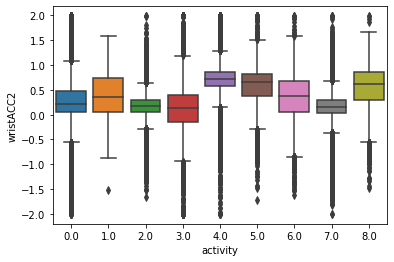

In [31]:
sns.boxplot(x="activity", y="wristACC2", data=datas)

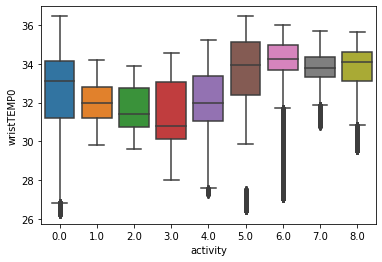

In [32]:
sns.boxplot(x="activity", y="wristTEMP0", data=datas)

# 4) Modèle de prédiction

## 4.1) Splitter les données en train et test set

On utilise le module train_test_split de sklearn pour séparer les données en train et test

In [33]:
from sklearn.model_selection import train_test_split
X_all = datas.drop(['activity', 'subject'], axis=1)
y_all = datas['activity']
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=123)

## 4.2) Algorithmes de prédiction
### 4.2.1) Random Forest Classifier
#### Entraîner le modèle avec le train set

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 54)
rf.fit(X_train, y_train);
predictionsrf = rf.predict(X_test)

#### Accuracy du modèle

In [35]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, predictionsrf))

0.9867066978163073


#### Features importantes

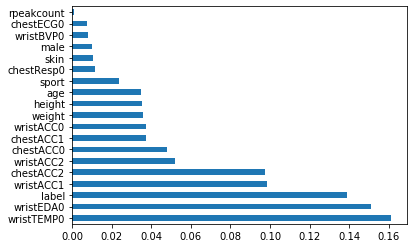

In [36]:
feat_importances = pd.Series(rf.feature_importances_, index=X_test.columns)
feat_importances.nlargest(19).plot(kind='barh')

#### Enregistrer le modèle dans 'rf_model.sav'

In [37]:
import pickle

filename = 'rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

#### Le charger dans une variable

In [38]:
filename = 'rf_model.sav'
rf = pickle.load(open(filename, 'rb'))
result = rf.score(X_test, y_test)
print(result)

0.9867066978163073


### 4.2.2) Naive Bayes

#### Entraîner le modèle avec le train set

In [39]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
predictionsnb = nb.predict(X_test)

#### Accuracy du modèle

In [40]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, predictionsnb))

0.5690247716872936


#### Enregistrer le modèle dans 'nb_model.sav'

In [41]:
import pickle

filename = 'nb_model.sav'
pickle.dump(nb, open(filename, 'wb'))

### 4.2.3) Nearest neighbours

#### Entraîner le modèle avec le train set

In [42]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(3)
kn.fit(X_train, y_train)
predictionskn = kn.predict(X_test)

#### Accuracy du modèle

In [43]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, predictionskn))

0.7181375861602919


#### Enregistrer le modèle dans 'kn_model.sav'

In [44]:
import pickle

filename = 'kn_model.sav'
pickle.dump(kn, open(filename, 'wb'))